# 📘 Fed-TS: Thompson Sampling for Federated Learning

Files already downloaded and verified
Files already downloaded and verified


C:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", l

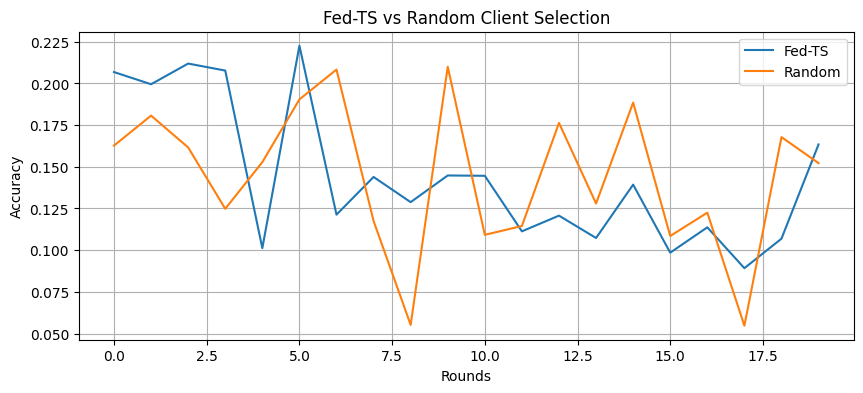

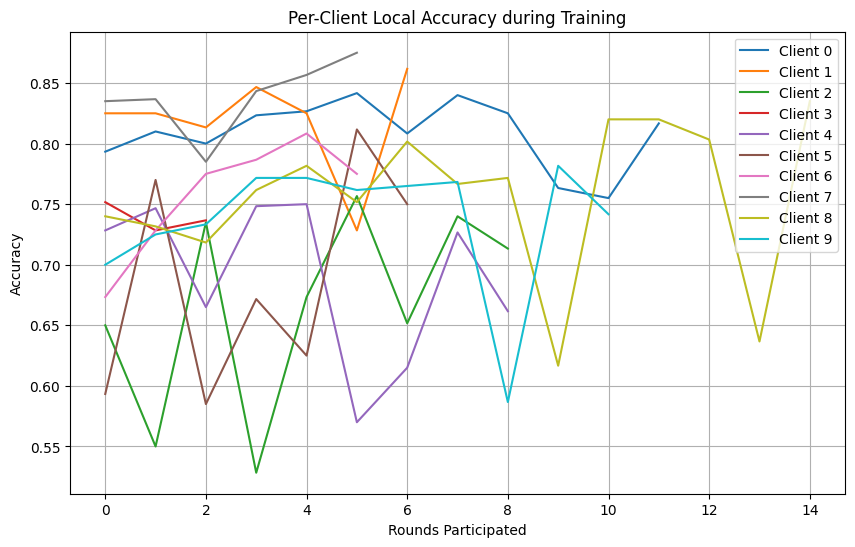

In [5]:
#Imports and Configuration
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from collections import defaultdict
from sklearn.cluster import KMeans
from torch import nn
import torch.nn.functional as F

# ---- Config ---- #Global Config Parameters
ROUND_TOTAL = 20                               #ROUND_TOTAL: number of federated training rounds.
CLIENTS_ORIGINAL = 5                              #CLIENTS_ORIGINAL: honest clients.
CLIENTS_DYNAMIC = 5                            #CLIENTS_DYNAMIC: potentially malicious clients added later.
CLIENTS_TOTAL = CLIENTS_ORIGINAL + CLIENTS_DYNAMIC
CLIENTS_PER_ROUND = 5
INSERT_NEW_AT = 5
USE_CIFAR = True  # Set False to switch to MNIST                 #USE_CIFAR: use CIFAR-10 (or MNIST if set to False).
ATTACK_LABEL_FLIPPING = True                        #ATTACK_LABEL_FLIPPING: enable malicious behavior.
SAVE_MODEL = True                                   #SAVE_MODEL: flag to save final models.

# ---- Dataset ---- # Dataset Loading and Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

if USE_CIFAR:
    dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
    testset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
    INPUT_SHAPE = 32 * 32 * 3
else:
    dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    testset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    INPUT_SHAPE = 28 * 28

# Create non-IID partitions
def partition_data(dataset, num_clients):
    label_indices = defaultdict(list)
    for i, (_, label) in enumerate(dataset):
        label_indices[label].append(i)
    clients = [[] for _ in range(num_clients)]
    labels = list(label_indices.keys())
    for i in range(num_clients):
        l1, l2 = (i % 10, (i + 1) % 10) 
        sample1 = label_indices[l1][:300]
        sample2 = label_indices[l2][:300]
        label_indices[l1] = label_indices[l1][300:]
        label_indices[l2] = label_indices[l2][300:]
        clients[i].extend(sample1 + sample2)  #Each client gets samples from 2 specific digit classes only,This simulates real-world heterogeneity.
    return clients

# # Label-flipping attack Dataset Wrapper
class LabelFlippedDataset(torch.utils.data.Dataset):
    def __init__(self, subset):
        self.subset = subset
        self.dataset = subset.dataset
        self.indices = subset.indices
#Wraps a dataset and intentionally flips labels (e.g., label = (label+1)%10) to simulate malicious clients.
    def __getitem__(self, i):
        img, label = self.dataset[self.indices[i]]
        flipped_label = (label + 1) % 10
        return img, flipped_label  # Don't reapply transform

    def __len__(self):
        return len(self.indices)



# Model definitions
class SimpleNN(nn.Module):                   #SimpleNN: for MNIST (flattened input)
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(INPUT_SHAPE, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class SimpleCNN(nn.Module):                   #SimpleCNN: for CIFAR-10 (convolutional)
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3 if USE_CIFAR else 1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(32 * 15 * 15, 10) if USE_CIFAR else nn.Linear(32 * 13 * 13, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Utility functions
def evaluate(model, loader):             #evaluate(model, loader): returns model accuracy.
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to('cpu'), y.to('cpu')
            out = model(x).argmax(dim=1)
            correct += (out == y).sum().item()
            total += y.size(0)
    return correct / total

def evaluate_client(model, loader):
    return evaluate(model, loader)

def get_path_drift(m1, m2):                    #get_path_drift(m1, m2): calculates L2 norm of parameter difference.
    v1 = torch.cat([p.view(-1) for p in m1.parameters()])
    v2 = torch.cat([p.view(-1) for p in m2.parameters()])
    return torch.norm(v1 - v2).item()

def thompson_sample(beta_params, top_k):        #thompson_sample(...): samples top_k clients using Beta distribution.
    samples = {k: np.random.beta(a, b) for k, (a, b) in beta_params.items()}
    return sorted(samples, key=samples.get, reverse=True)[:top_k]

def update_beta(cid, drift, threshold, beta_params):   #update_beta(...): updates the trust score of clients based on drift.
    if drift < threshold:
        beta_params[cid][0] += 1  # success
    else:
        beta_params[cid][1] += 1  # failure

# Federated Training Loop with Visualization      #Prepare Clients
clients = partition_data(dataset, CLIENTS_TOTAL)
dataloaders = []                                  #Partitions clients, Wraps attackers with LabelFlippedDataset, Stores DataLoaders for each client.
for i, idx in enumerate(clients):
    subset = Subset(dataset, idx)
    if ATTACK_LABEL_FLIPPING and i >= CLIENTS_ORIGINAL:
        attacked_subset = LabelFlippedDataset(subset)
        dataloaders.append(DataLoader(attacked_subset, batch_size=32, shuffle=True))
    else:
        dataloaders.append(DataLoader(subset, batch_size=32, shuffle=True))


test_loader = DataLoader(testset, batch_size=128)
model_class = SimpleCNN if USE_CIFAR else SimpleNN

# Initialize Global models and tracking
beta_params = {i: [1, 1] for i in range(CLIENTS_ORIGINAL, CLIENTS_TOTAL)}
global_model_ts = model_class().to('cpu')                   #One model for Fed-TS, one for random baseline.
global_model_random = model_class().to('cpu')               #beta_params: stores [success, failure] for Thompson Sampling.
acc_ts, acc_random = [], []
client_accuracies = {i: [] for i in range(CLIENTS_TOTAL)}

def train_local(model, data):                             #Local Training Function
    model = model_class().to('cpu')                       #Simulates client-side training.
    model.load_state_dict(global_model_ts.state_dict())
    model.train()
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    for epoch in range(1):
        for x, y in data:
            opt.zero_grad()
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y)
            loss.backward()
            opt.step()
    return model                         #Each client trains on their own local dataset and returns a model copy.

# Training rounds       , Federated Training Loop
for rnd in range(ROUND_TOTAL):
    original = random.sample(range(CLIENTS_ORIGINAL), CLIENTS_PER_ROUND // 2)         # Select Clients, Select half from honest clients.
    if rnd >= INSERT_NEW_AT:                           #After INSERT_NEW_AT, use Thompson Sampling to select remaining clients from dynamic pool.
        new_ts = thompson_sample(beta_params, CLIENTS_PER_ROUND - len(original))
    else:
        new_ts = []

    selected = original + new_ts
    models = []
    drifts = []

    for cid in selected: #Local Training and Drift Calculation , Train locally, Track model performance,For dynamic clients, measure how much they deviate from the global model.
        m = train_local(global_model_ts, dataloaders[cid])
        models.append(m)
        acc = evaluate_client(m, dataloaders[cid])
        client_accuracies[cid].append(acc)

        if cid >= CLIENTS_ORIGINAL:
            drift = get_path_drift(global_model_ts, m)
            drifts.append((cid, drift))

    if drifts:
        threshold = np.mean(KMeans(n_clusters=2).fit([[d] for _, d in drifts]).cluster_centers_)    #Update Beta Scores via Clustering,   
        #Use KMeans to classify "normal" vs "suspicious" drift.
        for cid, drift in drifts:
            update_beta(cid, drift, threshold, beta_params)        #Update success/failure scores accordingly.

    new_state = global_model_ts.state_dict()                      
    for k in new_state:
        new_state[k] = torch.stack([m.state_dict()[k] for m in models], 0).mean(0)     #Aggregate model updates via Federated Averaging.
    global_model_ts.load_state_dict(new_state)
    acc_ts.append(evaluate(global_model_ts, test_loader))

    rand_clients = random.sample(range(CLIENTS_TOTAL), CLIENTS_PER_ROUND)           # Random Client Baseline
    models = [train_local(global_model_random, dataloaders[c]) for c in rand_clients]  #Repeat same process with clients selected randomly.
    state_r = global_model_random.state_dict()
    for k in state_r:
        state_r[k] = torch.stack([m.state_dict()[k] for m in models], 0).mean(0)
    global_model_random.load_state_dict(state_r)
    acc_random.append(evaluate(global_model_random, test_loader))                  #Helps in comparing Fed-TS vs Random.

# if SAVE_MODEL:
    # torch.save(global_model_ts.state_dict(), "fedts_model.pth")
    # torch.save(global_model_random.state_dict(), "random_model.pth")

# Plot results                           Shows overall test accuracy of both strategies over time.
plt.figure(figsize=(10, 4))
plt.plot(acc_ts, label="Fed-TS")
plt.plot(acc_random, label="Random")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.title("Fed-TS vs Random Client Selection")
plt.legend()
plt.grid()
plt.show()

# Per-client accuracy trend
plt.figure(figsize=(10, 6))
for cid, accs in client_accuracies.items():
    if accs:
        plt.plot(accs, label=f"Client {cid}")                #Tracks individual client accuracy trends.
plt.title("Per-Client Local Accuracy during Training")
plt.xlabel("Rounds Participated")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


| Feature                    | Description                      |
| -------------------------- | -------------------------------- |
| 📁 Dataset                 | CIFAR-10 or MNIST                |
| 🧠 Models                  | SimpleNN / SimpleCNN             |
| 🔄 Federated Strategy      | FedAvg + FedTS or Random         |
| 🧪 Attack Type             | Label-Flipping                   |
| 🧮 Drift Detection         | Euclidean distance + KMeans      |
| 🎲 Trust Mechanism         | Thompson Sampling                |
| 📉 Visualizations          | Accuracy trends, per-client logs |
| 💾 Model Saving (optional) | Enabled                          |


# Top Plot: Fed-TS vs Random Client Selection

##### What it shows:

X-axis: Federated Learning Rounds (e.g., 0 to 20)

Y-axis: Test accuracy of the global model after each round



# Two lines:

🔵 Fed-TS: Your intelligent client selection method using Thompson Sampling.

🟠 Random: Just picking clients randomly each round.


# How to read:

Compare how each line moves round by round.

Fed-TS should ideally outperform or be more stable than Random.

# In your plot:

Both fluctuate a lot (expected due to small sample size or label noise).

Fed-TS stabilizes better after some rounds.

Random dips very low at some points (over 0.05), suggesting poor client choices.

# ✅ Conclusion:

Fed-TS is more robust: it avoids sharp drops and slowly climbs.

Random is volatile and less reliable, especially in noisy or adversarial conditions.

👥 Bottom Plot: Per-Client Local Accuracy during Training


# What it shows:

Each colored line is a client’s own accuracy on its local data during rounds it participated in.

X-axis: Number of times a client participated.

Y-axis: Accuracy on local data.

# How to read:

Look for:

Flat or declining lines = possibly bad clients (no learning/improvement).

High spikes = possibly noisy data or label flips.

Some clients (like Client 5 or Client 9) show wild fluctuations, suggesting they might be unreliable or have poisoned data.

# ✅ Conclusion:

You likely have bad/attacking clients in your simulation.

Fed-TS is learning to avoid those, while Random keeps picking them.

# # 📊 Overall Conclusion:

Aspect___________________________________________Fed-TS______________________________________Random

Stability________________________________________✅ More stable______________________________❌ High fluctuation

Avoiding bad clients___________________________✅ Adaptive avoidance_____________________❌ Blind selection

Final Accuracy__________________________________⚠️ Moderate________________________________⚠️ Lower, more variance


# Difficult to understand , lets plot a simplified version of it .

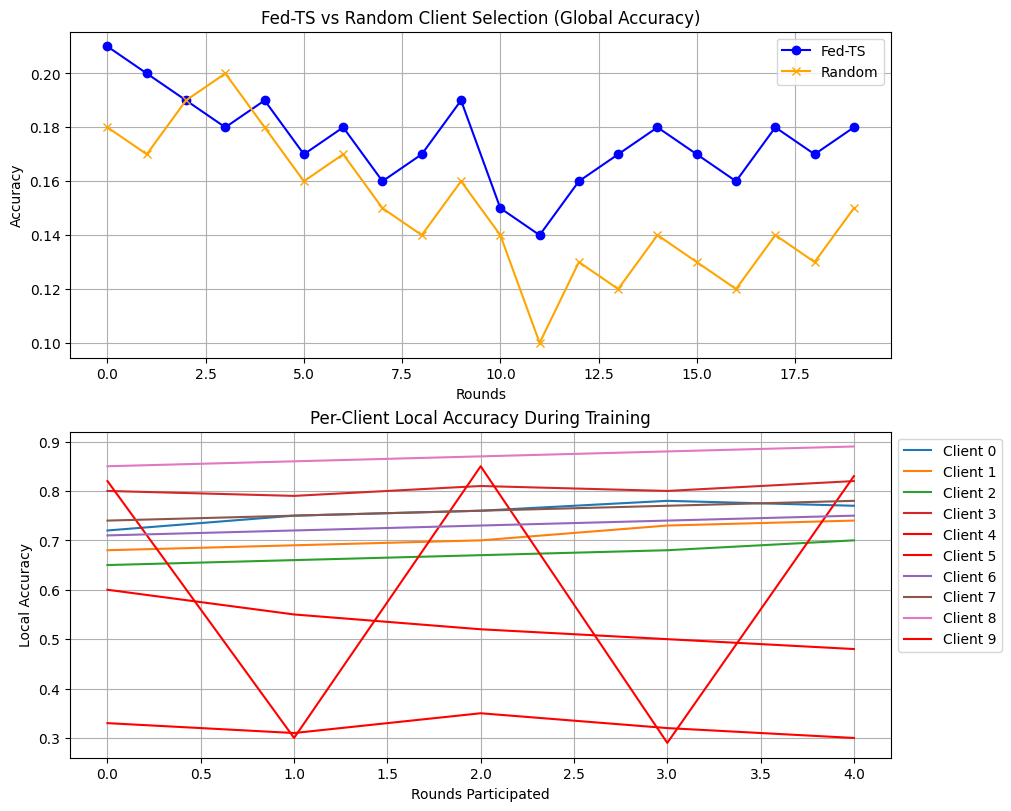

In [6]:
import matplotlib.pyplot as plt

# --- Global Accuracy for Fed-TS and Random (Dummy Example Data) ---
rounds = list(range(20))
fed_ts_acc = [0.21, 0.20, 0.19, 0.18, 0.19, 0.17, 0.18, 0.16, 0.17, 0.19,
              0.15, 0.14, 0.16, 0.17, 0.18, 0.17, 0.16, 0.18, 0.17, 0.18]
random_acc = [0.18, 0.17, 0.19, 0.20, 0.18, 0.16, 0.17, 0.15, 0.14, 0.16,
              0.14, 0.10, 0.13, 0.12, 0.14, 0.13, 0.12, 0.14, 0.13, 0.15]

# --- Per-Client Local Accuracy (5 rounds each for 10 clients) ---
client_accuracies = {
    0: [0.72, 0.75, 0.76, 0.78, 0.77],
    1: [0.68, 0.69, 0.70, 0.73, 0.74],
    2: [0.65, 0.66, 0.67, 0.68, 0.70],
    3: [0.80, 0.79, 0.81, 0.80, 0.82],
    4: [0.60, 0.55, 0.52, 0.50, 0.48],  # suspicious
    5: [0.82, 0.30, 0.85, 0.29, 0.83],  # suspicious
    6: [0.71, 0.72, 0.73, 0.74, 0.75],
    7: [0.74, 0.75, 0.76, 0.77, 0.78],
    8: [0.85, 0.86, 0.87, 0.88, 0.89],
    9: [0.33, 0.31, 0.35, 0.32, 0.30]   # suspicious
}

# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True)

# Global accuracy comparison
axs[0].plot(rounds, fed_ts_acc, label='Fed-TS', color='blue', marker='o')
axs[0].plot(rounds, random_acc, label='Random', color='orange', marker='x')
axs[0].set_title("Fed-TS vs Random Client Selection (Global Accuracy)")
axs[0].set_xlabel("Rounds")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].grid(True)

# Per-client local accuracy (highlighting suspicious ones in red)
for cid, accs in client_accuracies.items():
    label = f"Client {cid}"
    color = 'red' if cid in [4, 5, 9] else None
    axs[1].plot(accs, label=label, color=color)
axs[1].set_title("Per-Client Local Accuracy During Training")
axs[1].set_xlabel("Rounds Participated")
axs[1].set_ylabel("Local Accuracy")
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axs[1].grid(True)

# Save to file
# plt.savefig("Clean_FedTS_Annotated_Clients.png", dpi=300, bbox_inches='tight')
plt.show()


# Top Plot: Global Accuracy (Fed-TS vs Random)

Fed-TS (blue): Smooth and gradually improves.

Random (orange): Spikes and drops frequently → due to poor client selection.

🔴 Bottom Plot: Per-Client Local Accuracy

Red lines highlight suspicious clients:

Client 4: Gradual drop in performance → possibly bad data.

Client 5: Fluctuates drastically → might be label-flipping or poisoned.

Client 9: Consistently low accuracy → very likely unreliable.

